# MeanFlow

Mean Flows for One-step Generative Modeling, Geng et al., 2025. [arXiv:2505.13447](https://arxiv.org/abs/2505.13447)

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

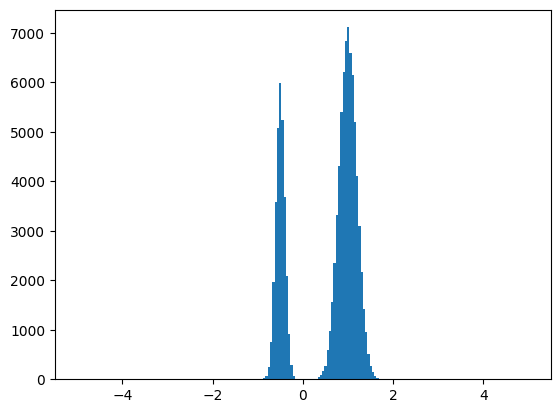

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and IMM framework.

In [2]:
import torch

from flowmodels.meanflow import MeanFlow
from utils import Backbone


class MeanFlowBackbone(Backbone):
    def forward(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor,
        d: torch.Tensor,
        label: torch.Tensor | None = None,
    ) -> torch.Tensor:
        return super().forward(x_t, torch.stack([t, d], dim=1), label)


COND = False
aux = 2 if not COND else 3
model = MeanFlow(MeanFlowBackbone(aux=aux))
model

MeanFlow(
  (velocity_estim): MeanFlowBackbone(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Training MeanFlow

Train the MeanFlow with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

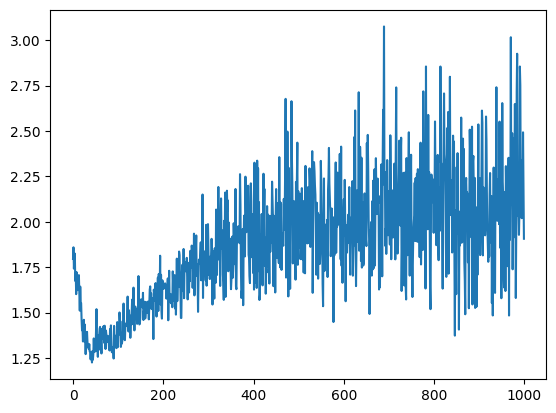

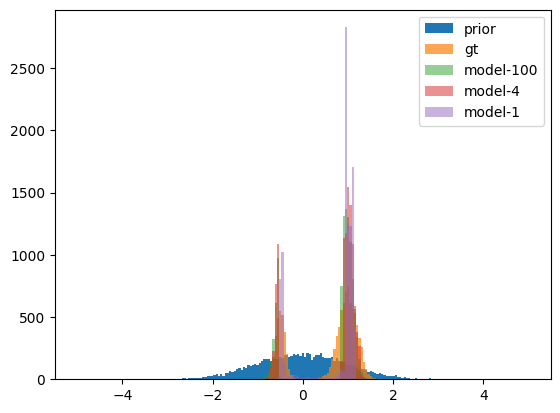

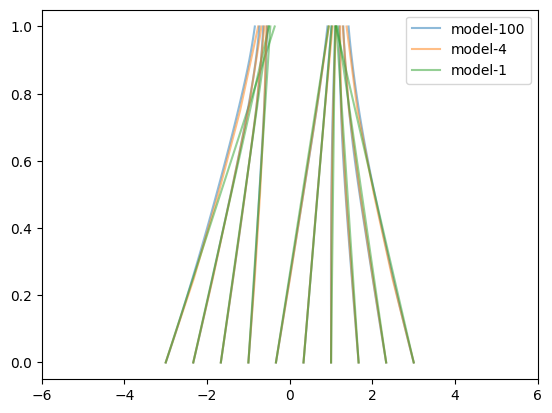

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048
MU = 0.0

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indices],
            label=Y[indices] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = model._debug_from_loss["meanflow/mse"]
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[100, 4, 1])